In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)

local


In [2]:
mine = kgs.dill_load(kgs.code_dir + '../res/mine.pickle')

In [3]:
expanded = []  # list[SolutionCollectionSquare], each with N_solutions=8
transformations = [
    (0.0,        False),  # Identity
    (np.pi/2,    False),  # 90° rotation
    (np.pi,      False),  # 180° rotation
    (3*np.pi/2,  False),  # 270° rotation
    (0.0,        True),   # Mirror (y -> -y)
    (np.pi/2,    True),   # Mirror + 90° rotation
    (np.pi,      True),   # Mirror + 180° rotation
    (3*np.pi/2,  True),   # Mirror + 270° rotation
    ]
for s in mine[0][:40]:
    # s is a SolutionCollectionSquare with 1 individual. expand it to 8 with the symmetries
    assert isinstance(s, kgs.SolutionCollectionSquare)
    assert s.xyt.shape[0] == 1, f"Expected 1 solution row, got {s.xyt.shape[0]}"
    base_xyt = s.xyt[0]  # (N_trees, 3) on GPU
    base_h = s.h[0]      # (3,) on GPU: [size, x_offset, y_offset]
    n_trees = base_xyt.shape[0]
    cx = base_h[1]
    cy = base_h[2]
    x0 = base_xyt[:, 0] - cx
    y0 = base_xyt[:, 1] - cy
    t0 = base_xyt[:, 2]
    xyt8 = cp.empty((8, n_trees, 3), dtype=base_xyt.dtype)
    for k, (rot_angle, do_mirror) in enumerate(transformations):
        x = x0
        y = y0
        t = t0
        if do_mirror:
            y = -y
            t = cp.pi - t
        if rot_angle != 0.0:
            c = np.cos(rot_angle)
            s_ = np.sin(rot_angle)
            xr = x * c - y * s_
            yr = x * s_ + y * c
            tr = t + rot_angle
        else:
            xr = x
            yr = y
            tr = t
        tr = cp.remainder(tr, 2 * np.pi)  # keep in [0, 2π)
        xyt8[k, :, 0] = xr + cx
        xyt8[k, :, 1] = yr + cy
        xyt8[k, :, 2] = tr
    h8 = cp.tile(base_h[cp.newaxis, :], (8, 1))
    expanded.append(kgs.SolutionCollectionSquare(xyt=xyt8, h=h8, use_fixed_h=s.use_fixed_h, periodic=False))

In [4]:
type(s)

kaggle_support.SolutionCollectionSquare

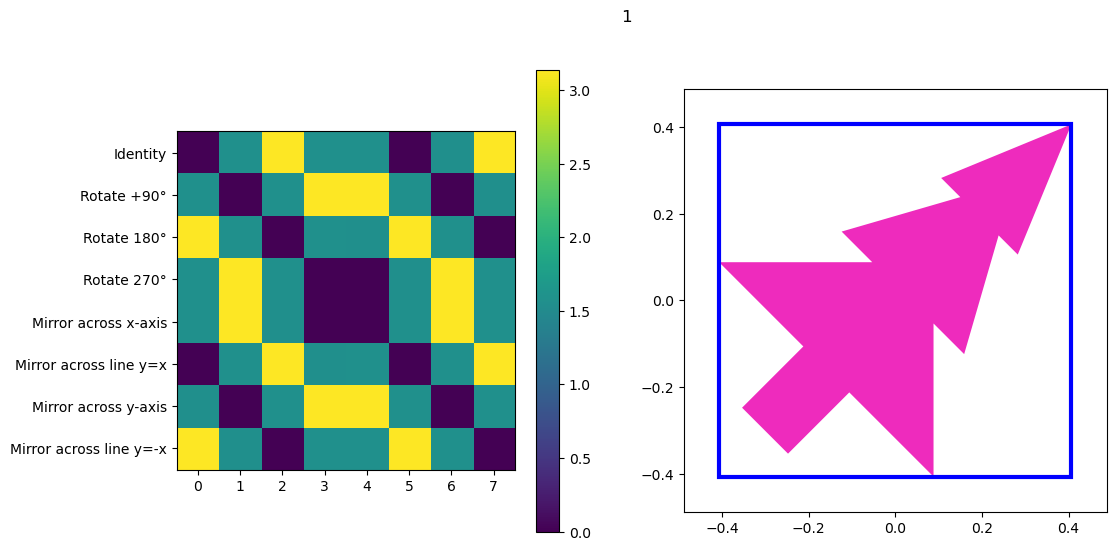

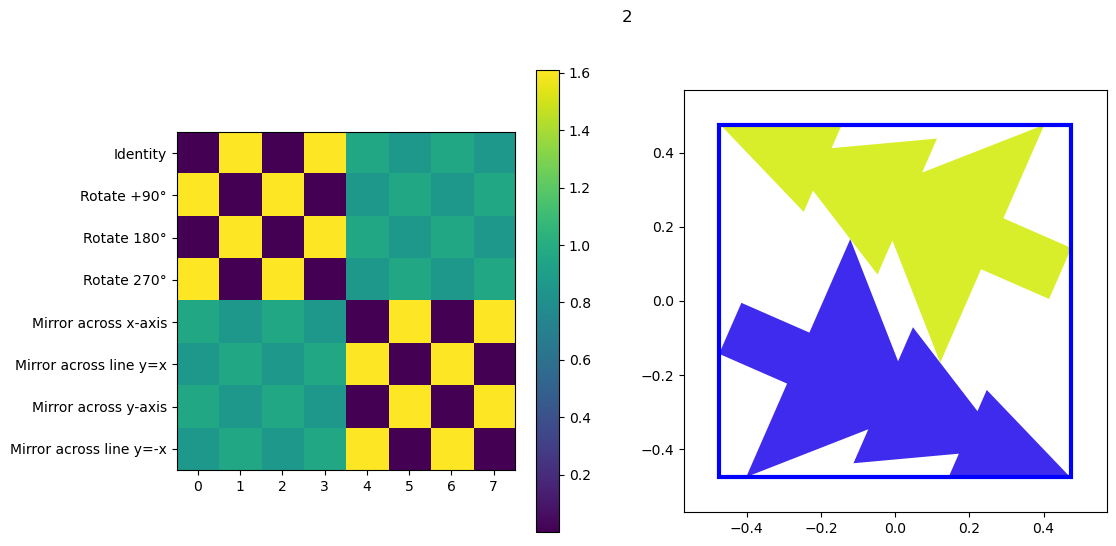

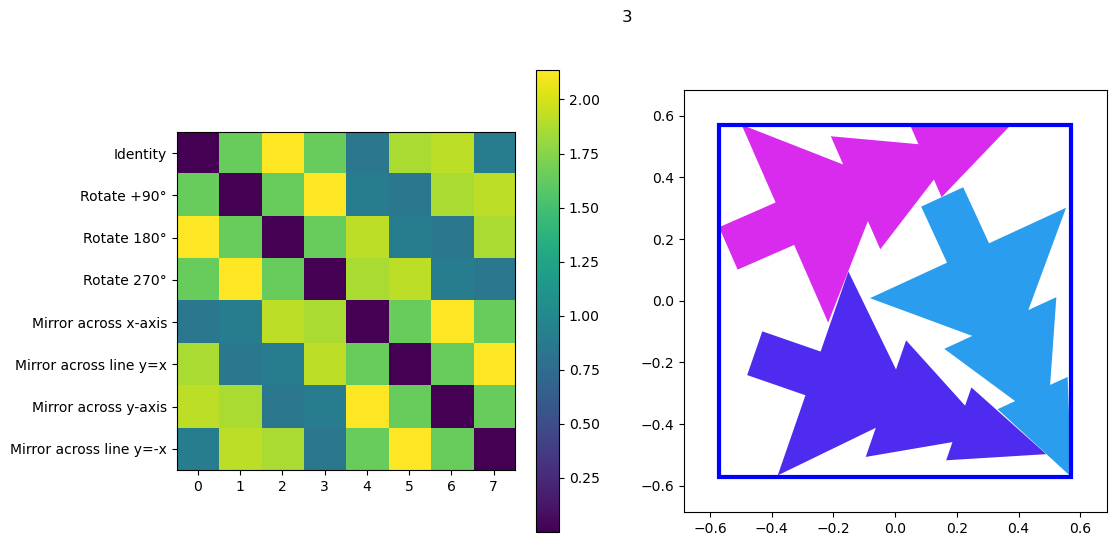

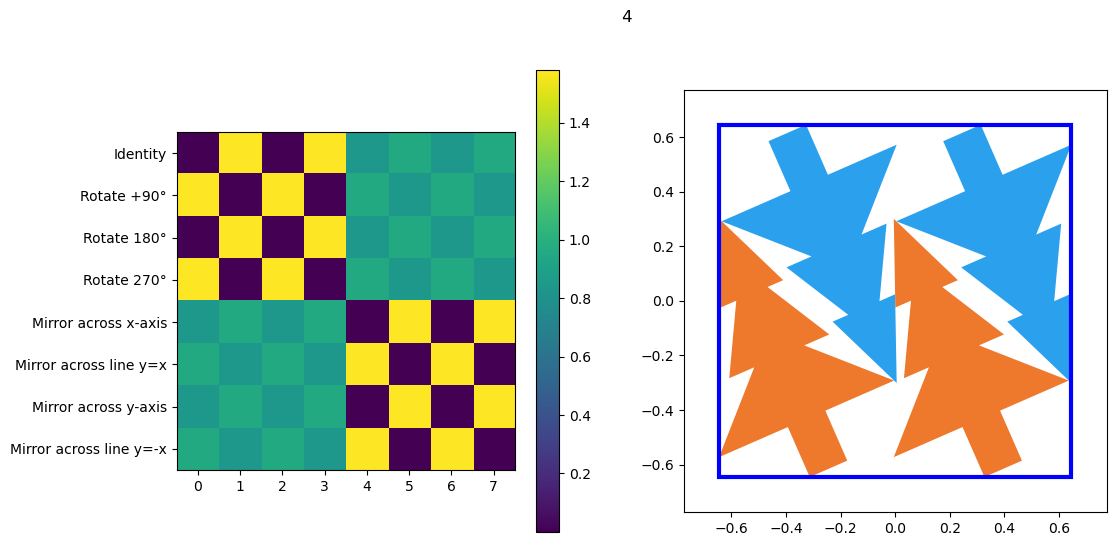

In [9]:
for e in expanded[:4]:
    matrix = kgs.compute_genetic_diversity_matrix(e.xyt, e.xyt, transform=False)
    matrix /= e.N_trees
    import matplotlib.pyplot as plt
    labels = [
        "Identity",
        "Rotate +90°",
        "Rotate 180°",
        "Rotate 270°",
        "Mirror across x-axis",
        "Mirror across line y=x",
        "Mirror across y-axis",
        "Mirror across line y=-x",
    ]
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    im = ax[0].imshow(matrix.get())
    fig.colorbar(im, ax=ax[0])
    ax[0].set_yticks(range(len(labels)))
    ax[0].set_yticklabels(labels)
    plt.suptitle(e.N_trees)
    pack_vis_sol.pack_vis_sol(e, ax=ax[1])